In [58]:
import matplotlib.pyplot as plt
import qtensor
import networkx as nx
import numpy as np
from qtensor.optimisation.kahypar_ordering import generate_TN as TN

In [116]:
def hg2graph_star(hg: TN.Hypergraph):
    graph = nx.DiGraph()
    verts = sum(hg.values(), [])
    for iedge, edge in hg.items():
        if iedge in verts:
            raise Exception(f'Edge has same label as vertex: {iedge}')
            
        if len(edge)==1:
            continue
            
        if len(edge) == 2:
            graph.add_edge(*edge)
            graph.add_edge(*reversed(edge))
            continue
            
        for vertex in edge:
            graph.add_edge(iedge, vertex)
            
    return graph
        
def hg2graph_triangle(hg: TN.Hypergraph):
    import itertools
    graph = nx.Graph()
    verts = sum(hg.values(), [])
    for iedge, edge in hg.items():
        for u, v in itertools.product(edge, edge):
            if u>v:
                graph.add_edge(u, v)
    return graph

In [170]:
p = 3
g = qtensor.toolbox.bethe_graph(p, degree=3)
g = nx.path_graph(11)
comp = qtensor.DefaultQAOAComposer(g, gamma=[.1]*p, beta=[.2]*p)
comp.energy_expectation_lightcone((5, 6))
hg = TN.circ2tn(comp.circuit)


In [344]:
def draw_hypergraph(hg, with_labels=False):
    g_triangle = hg2graph_triangle(hg)
    g_star = hg2graph_star(hg)
    
    pos = nx.kamada_kawai_layout(g_triangle)
    node_sizes = [ 60 if x in hg.keys() else 30 for x in g_star.nodes ]
    node_colors = [ 'yellow' if x in hg.keys() else 'blue' for x in g_star.nodes ]

    for edge_v, edge in hg.items():
        pp = [pos[v] for v in edge]
        edge_pos = np.mean(pp, axis=0)
        pos[edge_v] = edge_pos

    nx.draw_networkx_nodes(g_star, pos, node_size=node_sizes, node_color=node_colors)
    if with_labels:
        nx.draw_networkx_labels(g_star, pos)
    x = nx.draw_networkx_edges(g_star, pos, arrowstyle='wedge', node_size=node_sizes)

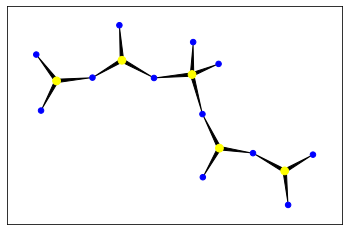

In [345]:
draw_hypergraph(hg)

---

In [395]:
from qtree import optimizer as opt

def get_data_zz(gamma):
    builder = qtensor.QtreeBuilder
    
    gate = builder.operators.ZZ(0, 1, alpha=2*gamma)
    return gate.gen_tensor()

def get_data_x(beta):
    builder = qtensor.QtreeBuilder
    
    gate = builder.operators.XPhase(0, alpha=2*beta)
    return gate.gen_tensor()


def get_tn(p, gamma, beta):
    tensors = []
    mid_end = 2*(p-1) + 1
    mid_out = mid_end + (p-1) + 1
    out_vars = [opt.Var(i, size=2, name=f'o_{i}') for i in range(mid_out, mid_out+2)]
    mid_vars = [opt.Var(p, size=2, name=f'v_{p}')]*2
    tensors.append(
        opt.Tensor('ZZ', indices=(out_vars[0], mid_vars[0]), data=get_data_zz(gamma[p-1]) )
    )
    tensors.append(
        opt.Tensor('ZZ+', indices=(out_vars[1], mid_vars[0]), data=get_data_zz(gamma[p-1]).T.conjugate())
    )
    for i in range(1, p):
        
        
        out_vars += [opt.Var(i, size=2, name=f'o_{i}') for i in
                     [mid_end + p-i,  mid_end + 2*p - p+1+i]
                    ]
        mid_vars += [opt.Var(i, size=2, name=f'v_{i}') for i in 
                     [p-i, p-i+2*i]
                    ]
        print('mid var', mid_vars)
        print('oupt var', out_vars)
        tensors.append(
            opt.Tensor('X', indices=(mid_vars[-3], mid_vars[-1]), data=get_data_x(beta[p-i]) )
        )
        tensors.append(
            opt.Tensor('X+', indices=(mid_vars[-4], mid_vars[-2]), data=get_data_x(beta[p-i]).T.conjugate() )
        )
        
        tensors.append(
            opt.Tensor('ZZ', indices=(out_vars[-1], mid_vars[-1]), data=get_data_zz(gamma[p-i-1]) )
        )
        tensors.append(
            opt.Tensor('ZZ+', indices=(out_vars[-2], mid_vars[-2]), data=get_data_zz(gamma[p-i-1]).T.conjugate())
        )
        print('p-', p-i-1)
        
    xconj = get_data_x(beta[0]).T.conjugate()[0]
    tensors.append(
        opt.Tensor('X+', indices=(mid_vars[-2], ), data=xconj)
    )
    tensors.append(
        opt.Tensor('X', indices=(mid_vars[-1], ), data=get_data_x(beta[0])[0] )
    )
    in_vars = mid_vars[2:]
    return tensors, out_vars, in_vars
        
    

In [396]:
p = 3
gamma = [0.1]*p
beta  = [0.2]*p

In [397]:
tensors, out_vars, in_vars = get_tn(p=3, gamma=gamma, beta=beta)
tensors

mid var [v_3, v_3, v_2, v_4]
oupt var [o_8, o_9, o_7, o_10]
p- 1
mid var [v_3, v_3, v_2, v_4, v_1, v_5]
oupt var [o_8, o_9, o_7, o_10, o_6, o_11]
p- 0


[ZZ(o_8,v_3),
 ZZ+(o_9,v_3),
 X(v_3,v_4),
 X+(v_3,v_2),
 ZZ(o_10,v_4),
 ZZ+(o_7,v_2),
 X(v_4,v_5),
 X+(v_2,v_1),
 ZZ(o_11,v_5),
 ZZ+(o_6,v_1),
 X+(v_1),
 X(v_5)]

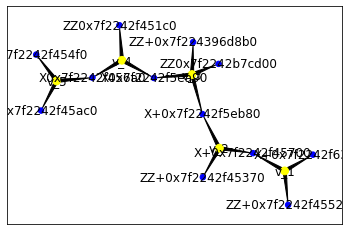

In [394]:
dual_hg = { t.name+str(hex(id(t))): t.indices for t in tensors }
hg = TN.dual_hg(dual_hg)
draw_hypergraph(hg, with_labels=True)

In [ ]:
def contract_path(gamma, beta):
    p = len(gamma)
    for i in range(p):
        tensors, out_vars, in_vars = gen_tn(i, gamma=gamma, beta=beta)
    
    